در اینجا ابتدا از فایل موجود، موقعیت شهر ها را ورودی گرفته و چند مولفه اول را نگهداری و یک خط خالی می خوانیم

In [1]:
# Open input file
# infile = open('gr229.tsp', 'r')
infile = open('pr1002.tsp', 'r')

# # Read instance header for the gr229
# Name = infile.readline().strip().split()[1] # NAME
# FileType = infile.readline().strip().split()[1] # TYPE
# Comment = infile.readline().strip().split()[1] # COMMENT
# Dimension = infile.readline().strip().split()[1] # DIMENSION
# EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
# DIsplayDataType = infile.readline().strip().split()[1] # DISPLAY_DATA_TYPE
# infile.readline()

# Read instance header for the pr1002
Name = infile.readline().strip().split()[2] # NAME
Comment = infile.readline().strip().split()[2] # COMMENT
FileType = infile.readline().strip().split()[2] # TYPE
Dimension = infile.readline().strip().split()[2] # DIMENSION
EdgeWeightType = infile.readline().strip().split()[2] # EDGE_WEIGHT_TYPE
infile.readline()

# Read node list
nodelist = []
N = int(Dimension)
for i in range(N):
    x ,y = infile.readline().strip().split(' ')[1:]
    nodelist.append([float(x), float(y)])

# Close input file
infile.close()

حال داده ها را در آرایه نامپای نگهداری می کنیم

In [2]:
import numpy as np
cor = np.array(nodelist)

این کتابخانه باعث می شود برنامه ما سریع تر اجرا شود.

به این صورت عمل می کند که کد را تبدیل به برنامه 

C

می کند

In [3]:
from numba import njit

در اینجا جمعیت اولیه را می سازیم که هر کدام از اعضا آن جایگشتی از شهر های ما است

‌ ***حتما برای هر برنامه، طول کوروموزوم را تغییر دهید (در صورت لزوم***)

In [4]:
@njit
def data_creation(population): #remember to change the n = 1002 for pr and n = 229 for gr
    data = np.zeros((population, 1002, 2))
    for i in range(population):
        data[i] = cor[np.random.permutation(1002)]
    return data

سپس تابع ارزش را داریم که به صورت جمع فاصله هر دو شهر متوالی از (به صورت دوری) هم در جایگشت ورودی به تابع بدست می آید

در واقع جمع فاصله هر دو شهر متوالی به همراه فاصله شهر اول و آخر

In [5]:
import math
@njit
def fitness(data):
    fit = 0
    for i in range(len(data)-1):
        fit += math.sqrt((data[i][0] - data[i+1][0])**2 + (data[i][1] - data[i+1][1])**2)
    fit += math.sqrt((data[0][0] - data[-1][0])**2 + (data[0][1] - data[-1][1])**2)
    return fit

در اینجا برای اولین بار ارزش هر جایگشت را حساب می کنیم

ارزش = fitness

In [6]:
@njit
def first_fit_calc(population, data):
    fitness_data = np.zeros(population)
    for i in range(population):
        fitness_data[i] = fitness(data[i])
    return fitness_data

حال به انتخاب می رسیم.

برای انتخاب والدین برای بازترکیب، از روش انتخاب مسابقه ای استفاده می کنیم.

به این صورت عمل می کنیم که به صورت تصادفی از جمعیت ۳ عضو برداشته و کم ترین مقدار ارزش ( بهترین والد ) را انتخاب می کنیم.

دلیل انتخاب این روش، پویش و انتفاع مناسب است.

In [7]:
@njit
def tournament_selection(x, f, p):
    arr = [0, 0, 0]
    for i in range(3):
        arr[i] = np.random.randint(p)
        
    fit = [0, 0, 0]
    for i in range(3):
        fit[i] = f[arr[i]]
        
    return arr[fit.index(min(fit))]

برای بازترکیب، از روش ترکیبی استفاده می کنیم. زیرا بین روش ترتیبی و روش دوری برای حالت کوروموزوم جایگشتی، راحت تر عمل می کند و جایگشت های بهتری می سازد

In [8]:
@njit
def crossover(x1, x2, n):
    index1 = np.random.randint(n)
    index2 = np.random.randint(n)
    if(index1 > index2):
        index1, index2 = index2, index1
        
    arr1 = np.zeros((n, 2))
    arr2 = np.zeros((n, 2))
    arr1[index1:index2+1] = x1[index1:index2+1].copy()
    arr2[index1:index2+1] = x2[index1:index2+1].copy()
    
    j = index2+1
    k = index2+1
    
    key1 = 1
    key2 = 1
    for i in range(n):

        for s in range(n):
            if (x1[(index2+1+i)%n][0]==arr2[s][0] and x1[(index2+1+i)%n][1]==arr2[s][1]):
                key1 = 0
        if(key1):
            arr2[j%n] = x1[(index2+1+i)%n].copy()
            j = j+1
        key1 = 1
        
        for s in range(n):
            if (x2[(index2+1+i)%n][0]==arr1[s][0] and x2[(index2+1+i)%n][1]==arr1[s][1]):
                key2 = 0
        if(key2):
            arr1[k%n] = x2[(index2+1+i)%n].copy()
            k = k+1
        key2 = 1
            
#     print(index1)
#     print(index2)
#     print(arr1)
#     print(arr2)
    return arr1, arr2

برای جهش ابتدا روش درهم سازی در نظر گرفته شد، اما چون جایگشت رو خیلی زیاد تغییر می دهد (جواب ها خوب نبودند )، روش جا به جایی در نظر گرفته شد

In [9]:
def scramble_mutation(arr, n):
    index1 = np.random.randint(n)
    index2 = np.random.randint(n)
    if(index1 > index2):
        index1, index2 = index2, index1
    t = arr[index1].copy()
    arr[index1] = arr[index2].copy()
    arr[index2] = t
        
#     sub_arr = arr[index1:index2+1]
#     sub_arr = np.random.permutation(sub_arr)
#     arr[index1:index2+1] = sub_arr.copy()
#     print(index1)
#     print(index2)
#     print(arr)
    return arr

این تابع، تابع توقف ما است که بررسی می کند آیا جواب بهتر شده یا خیر

In [18]:
def stop_condition(fd, c, lm):
    if(min(fd) == 0):
        lm[0] = 0
        return(0)
    
    elif(min(fd) >= lm[0]):
        return(0.5)      
    
    elif(min(fd) < lm[0]):
        lm[0] = min(fd)
        return(1)

این تابع، تابع اصلی است که چند بار اجرا شده (دیفالت ۱۰ بار) تا بررسی کند که در اون تعداد بار، چند بار جواب ۰ بدست می آید.

A: در این بخش آرایه هایی که بعدا جواب ها را داخل آنها قرار می دهیم را می سازیم.

best_gen

پیشرفت بهترین حالت را در هر نسل نشان می دهد که نمودار آن کشیده شده

B: در این قسمت داده های اولیه را ساخته و ارزش آنها را محاسبه می کنیم

C: در این بخش انتخاب والدین را انجام می دهیم

D: در این بخش با احتمال ۰.۹۵ با والد های انتخاب شده، بازترکیب انجام می دهیم

E: در این بخش با احتمال های مختلف، فرزند های تولید شده را جهش می دهیم

F: در این قسمت والیدن را براساس ارزش آنها مرتب می کنیم

G: در این قسمت فرزندان را براساس ارزش آنها مرتب می کنیم

H: در این بخش ۵۰ درصد برتر فرزندان را با ۵۰ درصد ضعیف والدین جا به جا می کنیم (جایگزینی)

In [11]:
import time
def genetic_algorithm(population, iteration, mu_chance, s=1, n=229):
    res_min = np.zeros(s) #(A)
    res_per = np.zeros((s, n, 2))
    best_gen = []
    for index in range(s):
        count = 0
        last_min = [100000000]
        gen = []

        data = data_creation(population) #(B)
        fitness_data = first_fit_calc(population, data)

        while(stop_condition(fitness_data, count, last_min) != 0 and count < iteration):
            if (stop_condition(fitness_data, count, last_min) == 0.5):
                count += 1
            else:
                count = 0
            
            if (stop_condition(fitness_data, count, last_min) == 1):
                best_gen = gen.copy()
                gen = []
                
            children = []
            for i in range(int(population/2)):
                arr_index = []
                child = []
                for i in range(2): #(C)
                    z = tournament_selection(data, fitness_data, population)
                    arr_index.append(z)
                chance = np.random.rand()
                if(chance <= 0.95): #(D)
                    child1, child2 = crossover(data[arr_index[0]], data[arr_index[1]], n)
                    child.append(child1)
                    child.append(child2)
                else:
                    child1, child2 = data[arr_index[0]], data[arr_index[1]]
                    child.append(child1)
                    child.append(child2)

                chance = np.random.rand()
                if(chance <= mu_chance):   #(E)
                    child[0], child[1] = scramble_mutation(child[0], n), scramble_mutation(child[1], n)
                children.append(child[0])
                children.append(child[1])

            #----------------------------------------------------------------

            for i in range(population): #(F)
                fitness_data[i] = fitness(data[i])

            sorted_fitness_data = np.sort(fitness_data)
            sorted_data = np.zeros((population, n, 2))

            for i in range(population):
                l = np.where(fitness_data == sorted_fitness_data[i])
                for j in range(len(l)):
                    sorted_data[i+j] = data[l[0][j]].copy()
                i = i + len(l)
            data = sorted_data.copy()
            fitness_data = sorted_fitness_data.copy()

            #-------------------------------------------------------------------

            pop_child = len(children) #(G)
            fitness_data_child = np.zeros(pop_child)

            for i in range(pop_child):
                fitness_data_child[i] = fitness(children[i])

            sorted_fitness_data_child = np.sort(fitness_data_child)
            sorted_child = np.zeros((pop_child, n, 2))

            for i in range(pop_child):
                l = np.where(fitness_data_child == sorted_fitness_data_child[i])
                for j in range(len(l)):
                    sorted_child[i + j] = children[l[0][j]].copy()
                i = i + len(l)
            children = sorted_child.copy()
            fitness_data_child = sorted_fitness_data_child.copy()

            #-------------------------------------------------------------------

            for i in range(int(0.5*(population))): #(H)
                data[-1*(i+1)] = children[i].copy()
                fitness_data[-1*(i+1)] = fitness_data_child[i].copy()
            
            gen.append(min(fitness_data))

        res_min[index] = last_min[0]
        res_per[index] = data[np.where(fitness_data == min(fitness_data))[0][0]]
        
    if (best_gen == []):
        best_gen = gen.copy()

    return res_min, res_per, best_gen

In [12]:
import matplotlib.pyplot as plt
import numpy as np

حال برای داده های اول امتحان می کنیم

gr229

حال حالت های مختلف را امتحان می کنیم تا ببینیم آیا به جواب می رسد یا خیر

ابتدا جمعیت را روی ۱۰ و تعداد تکرار را روی ۱۰۰ میگذاریم در حالی که احتمال جهش برابر ۱/۲۲۹ است.

تابع را ۱۰ بار اجرا می کنیم و نمودار تغییر نسل بهترین جواب را خروجی می دهیم

[13565.05147604 15080.61798723 14499.51176001 13340.82345396
 14316.10206475 13953.51088024 13698.23440726 14520.41469759
 14201.69158028 14126.1932595 ]
[[  34.48  113.39]
 [  31.32   65.3 ]
 [  29.36   52.32]
 [  29.2    47.59]
 [  52.16  104.2 ]
 [  50.26   30.31]
 [  39.55   41.17]
 [  55.45   37.35]
 [  36.2    43.08]
 [  46.21   48.03]
 [  22.38  120.17]
 [  18.58   72.5 ]
 [  38.25   27.09]
 [  30.2    48.16]
 [  26.55   75.49]
 [  25.03  121.3 ]
 [  43.1   131.56]
 [  30.39  104.04]
 [  21.3    39.12]
 [  54.43   20.3 ]
 [  -9.26  159.57]
 [  47.55  106.53]
 [  16.47   96.1 ]
 [   4.56  114.55]
 [ -10.1   123.35]
 [  56.01   92.5 ]
 [  21.27   39.49]
 [  31.25   73.05]
 [  54.41   25.19]
 [  36.12   37.1 ]
 [  22.17  114.09]
 [  53.01  158.39]
 [ -23.42  133.53]
 [  -5.4   132.45]
 [  10.45  106.4 ]
 [  53.54   27.34]
 [  16.28  107.36]
 [   3.1   101.42]
 [  32.03  118.47]
 [  35.    135.45]
 [  10.42  122.34]
 [  35.4    51.26]
 [  37.16   49.36]
 [  52.03  113.3 ]
 [  25.17 

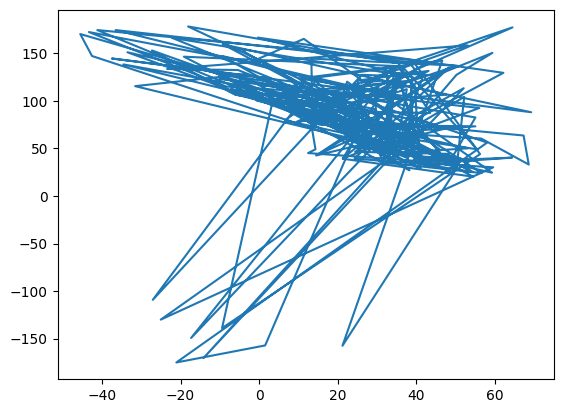

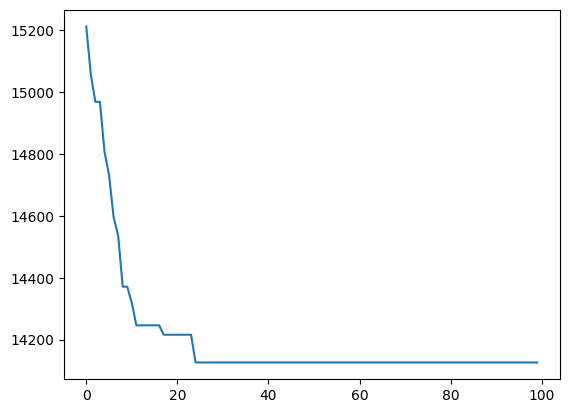

In [137]:
x, y, gen = genetic_algorithm(10, 100, 1/229, 10, 229) # data = 'gr229.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])
pt_arrx = np.zeros(229+1)
pt_arry = np.zeros(229+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(229):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[229] = s[0][0].copy()
pt_arry[229] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()

نمودار تغییرات خیلی خوبی ندارد، حال جمعیت را به ۵۰ افزایش داده و تعداد تکرار را به ۵۰ کاهش می دهیم.

همچنین احتمال جهش را روی ۰.۲ می گذاریم

[ 9863.08142628 10092.87676188  9453.57583661 10217.80791025
  7797.65447589  9512.47924708  9908.43412141 10399.5661429
  9545.8594361   9348.40838966]
[[  22.     96.05]
 [  43.48   87.35]
 [  49.5    73.1 ]
 [  43.15   76.57]
 [  31.25   73.05]
 [  46.21   48.03]
 [  41.01   28.58]
 [  39.56   32.52]
 [  47.14   39.42]
 [  58.     56.15]
 [  29.39  106.34]
 [  39.43  140.07]
 [  -3.43  128.12]
 [  22.17  114.09]
 [   7.04  125.36]
 [  35.06  129.03]
 [  34.4   135.3 ]
 [  48.27  135.06]
 [ -41.18  174.47]
 [  -5.07  119.24]
 [  -9.26  159.57]
 [ -19.16  146.48]
 [ -34.55  138.35]
 [  -3.2   114.35]
 [  17.58  102.36]
 [  29.2    47.59]
 [  41.43   44.49]
 [  51.4    39.1 ]
 [  13.05   80.17]
 [  15.23   44.12]
 [  36.2    43.08]
 [  32.04   34.46]
 [  49.5    24.  ]
 [  37.01   35.18]
 [  59.25   24.45]
 [  33.21   44.25]
 [  21.27   39.49]
 [  35.4    51.26]
 [  40.11   44.3 ]
 [  27.42   68.52]
 [  25.22   68.22]
 [  30.17   57.05]
 [  32.4    51.38]
 [  50.26   30.31]
 [  34.31  

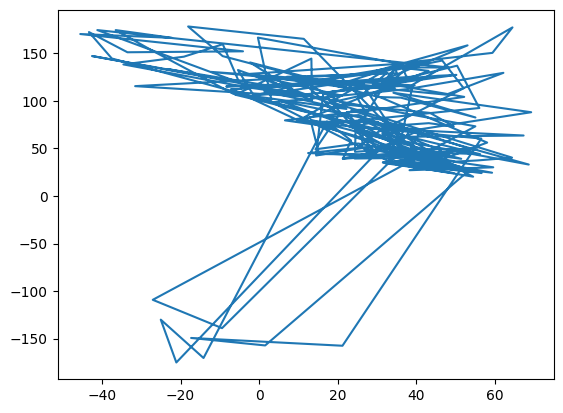

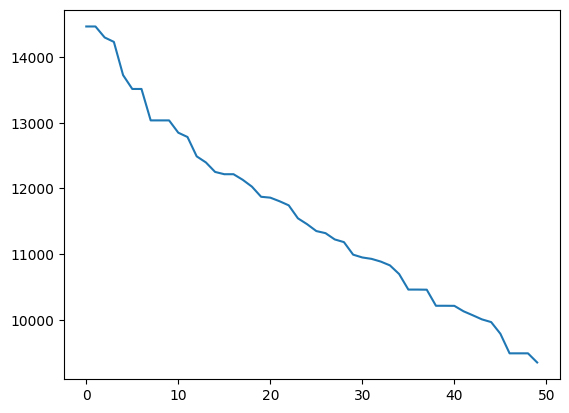

In [139]:
x, y, gen = genetic_algorithm(50, 50, 0.2, 10, 229) # data = 'gr229.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])

pt_arrx = np.zeros(229+1)
pt_arry = np.zeros(229+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(229):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[229] = s[0][0].copy()
pt_arry[229] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()

مشاهده می شود که نمودار خیلی بهتر تغییر می کند و همچنین پاسخ بهتر شده. حال دوباره جمعیت را افزایش داده و تکرار را روی ۱۰۰ می گذاریم

[7060.98422082 5200.64267252 7382.37253787 5425.79678092 7191.31419948]
[[  17.23   78.29]
 [  53.12   50.09]
 [  48.44   44.25]
 [  40.11   44.3 ]
 [  38.05   46.18]
 [  30.3    47.47]
 [  25.18   55.18]
 [  29.2    47.59]
 [  33.3    36.18]
 [  39.56   32.52]
 [  31.46   35.14]
 [  31.57   35.56]
 [  55.45   37.35]
 [  50.     36.15]
 [  36.2    43.08]
 [  43.15   76.57]
 [  25.2    83.  ]
 [  27.42   68.52]
 [  23.37   58.35]
 [  36.18   59.36]
 [  31.25   73.05]
 [  36.06  120.19]
 [  53.01  158.39]
 [  46.58  142.42]
 [  62.13  129.49]
 [  48.27  135.06]
 [  39.43  140.07]
 [  35.42  139.46]
 [  34.15  108.52]
 [  22.17  114.09]
 [ -37.49  144.58]
 [  -3.43  128.12]
 [ -19.16  146.48]
 [ -36.52  174.46]
 [ -33.52  151.13]
 [ -42.53  147.19]
 [ -10.1   123.35]
 [   1.33  110.2 ]
 [  11.33  104.55]
 [  -0.57  100.21]
 [  16.47   96.1 ]
 [  12.59   77.35]
 [   9.56   78.07]
 [  30.12   67.  ]
 [  28.4    77.13]
 [  26.55   75.49]
 [  35.28   44.28]
 [  36.12   37.1 ]
 [  33.53   35.3

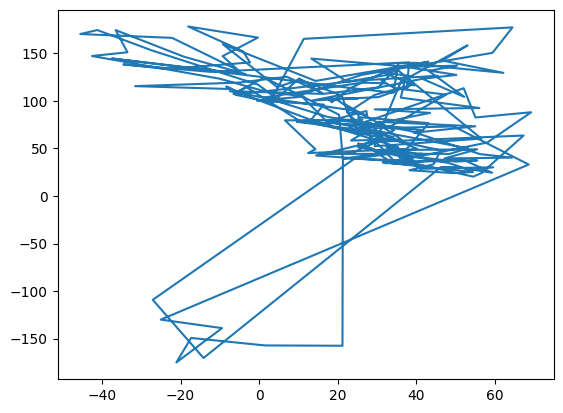

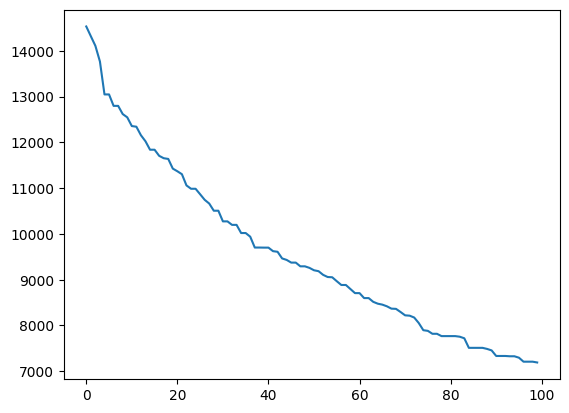

In [140]:
x, y, gen = genetic_algorithm(80, 100, 0.2, 5, 229) # data = 'gr229.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])

pt_arrx = np.zeros(229+1)
pt_arry = np.zeros(229+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(229):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[229] = s[0][0].copy()
pt_arry[229] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()

مشاهده می شود که دوباره نمودار خیلی بهتر تغییر می کند و همچنین پاسخ بهتر شده. حال تکرار را افزایش داده و روی ۲۰۰ می گذاریم

همچنین احتمال جهش را روی ۰.۴ می گذاریم

[3326.15059006]
[[  54.41   25.19]
 [  50.26   30.31]
 [  49.5    24.  ]
 [  47.14   39.42]
 [  41.43   44.49]
 [  40.23   49.51]
 [  26.13   50.35]
 [  25.17   51.32]
 [  34.19   47.04]
 [  36.2    43.08]
 [  39.45   37.02]
 [  38.43   35.3 ]
 [  33.3    36.18]
 [  31.57   35.56]
 [  39.55   41.17]
 [  37.55   40.14]
 [  32.04   34.46]
 [ -17.32 -149.34]
 [ -21.08 -175.12]
 [ -14.16 -170.42]
 [   1.52 -157.2 ]
 [  21.19 -157.52]
 [  -9.45 -139.  ]
 [ -25.04 -130.06]
 [ -27.07 -109.22]
 [  14.48   42.57]
 [  29.2    47.59]
 [  30.2    48.16]
 [  37.16   49.36]
 [  35.28   44.28]
 [  35.4    51.26]
 [  27.42   68.52]
 [  11.33  104.55]
 [  22.17  114.09]
 [  31.14  121.28]
 [  39.08  117.12]
 [  39.01  125.45]
 [  36.06  120.19]
 [  34.15  108.52]
 [  36.03  103.41]
 [  30.39  104.04]
 [  27.28   89.39]
 [  29.4    91.09]
 [  22.     96.05]
 [  16.47   96.1 ]
 [  10.49   78.41]
 [  12.59   77.35]
 [  15.21   75.1 ]
 [  27.43   85.19]
 [  23.43   90.25]
 [  25.05  102.4 ]
 [  29.39  106.

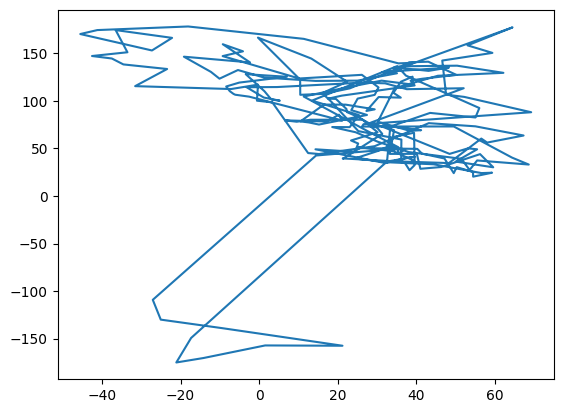

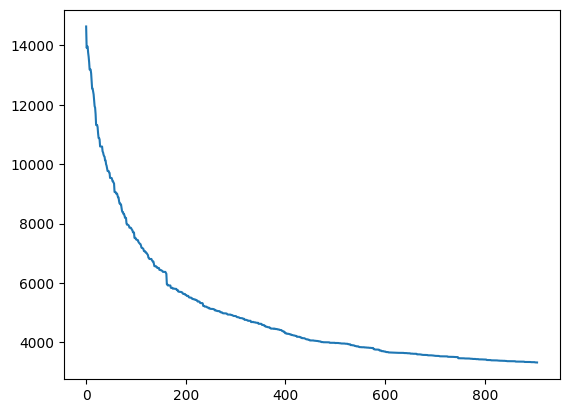

In [141]:
x, y, gen = genetic_algorithm(100, 200, 0.4, 1, 229) # data = 'gr229.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])

pt_arrx = np.zeros(229+1)
pt_arry = np.zeros(229+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(229):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[229] = s[0][0].copy()
pt_arry[229] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()

مشاهده می کنیم که یک منحنی خیلی خوب برای جهش ها به وجود آمده

دوباره جمعیت، تکرار و احتمال جهش را افزایش می دهیم

[2801.45805818]
[[  31.25   73.05]
 [  26.55   75.49]
 [  28.4    77.13]
 [  25.2    83.  ]
 [  25.36   85.07]
 [  23.43   90.25]
 [  22.2    91.5 ]
 [  20.3    85.5 ]
 [  17.42   83.18]
 [  13.05   80.17]
 [  10.49   78.41]
 [   6.56   79.51]
 [   9.56   78.07]
 [  12.59   77.35]
 [  15.21   75.1 ]
 [  18.58   72.5 ]
 [  17.23   78.29]
 [  16.47   96.1 ]
 [   4.56  114.55]
 [  -3.43  128.12]
 [  -5.4   132.45]
 [ -12.28  130.5 ]
 [ -10.1   123.35]
 [  -8.39  115.13]
 [  -6.54  107.36]
 [  -6.1   106.48]
 [  -2.55  104.45]
 [  -0.57  100.21]
 [   3.35   98.4 ]
 [   5.25  100.2 ]
 [  16.28  107.36]
 [  30.36  114.17]
 [  32.03  118.47]
 [  35.06  129.03]
 [  32.48  129.55]
 [  10.18  123.54]
 [ -19.16  146.48]
 [ -27.28  153.02]
 [ -33.52  151.13]
 [ -37.49  144.58]
 [ -42.53  147.19]
 [ -36.52  174.46]
 [ -41.18  174.47]
 [ -43.32  172.38]
 [ -45.52  170.3 ]
 [ -34.55  138.35]
 [ -31.56  115.5 ]
 [ -23.42  133.53]
 [ -22.16  166.27]
 [ -18.08  178.25]
 [  -0.32  166.55]
 [  -9.26  159.

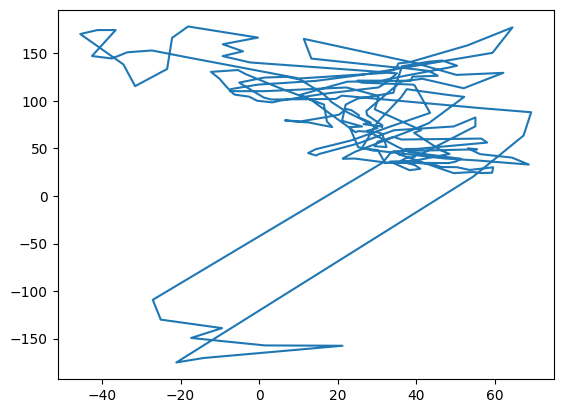

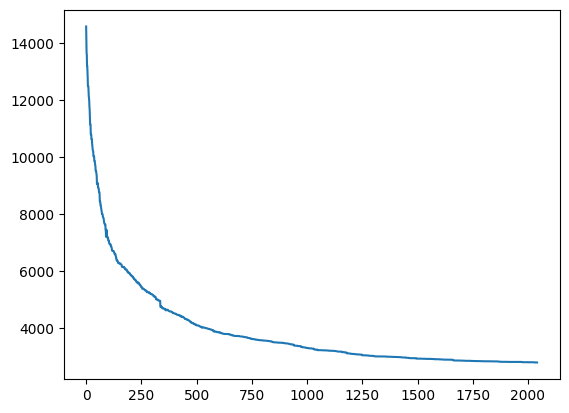

In [142]:
x, y, gen = genetic_algorithm(120, 300, 0.5, 1, 229) # data = 'gr229.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])

pt_arrx = np.zeros(229+1)
pt_arry = np.zeros(229+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(229):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[229] = s[0][0].copy()
pt_arry[229] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()

نمودار باز هم بهتر شد.

این دفعه جمعیت را روی ۱۰۰ بر می گردانیم و تعداد تکرار را به ۶۰۰ افزایش می دهیم

همچنین احتمال جهش را روی ۰.۶ می گذاریم

مشاهده می شود که به مقدار ۲۳۲۰ رسیده و نمودار به خوبی تغییر می کند

[2320.02231085]
[[  47.14   39.42]
 [  36.12   37.1 ]
 [  34.44   36.43]
 [  24.28   39.36]
 [  21.3    39.12]
 [  21.27   39.49]
 [  14.48   42.57]
 [  15.23   44.12]
 [  12.45   45.12]
 [  14.32   49.08]
 [  25.18   55.18]
 [  23.37   58.35]
 [  24.52   67.03]
 [  25.22   68.22]
 [  23.02   72.37]
 [  21.09   79.06]
 [  25.05  102.4 ]
 [  29.39  106.34]
 [  34.48  113.39]
 [  37.55  112.3 ]
 [  39.55  116.25]
 [  39.08  117.12]
 [  38.53  121.35]
 [  39.01  125.45]
 [  37.33  126.58]
 [  31.14  121.28]
 [  25.03  121.3 ]
 [  22.38  120.17]
 [  14.35  121.  ]
 [   4.56  114.55]
 [   1.33  110.2 ]
 [  -2.55  104.45]
 [   1.17  103.51]
 [   3.1   101.42]
 [   5.25  100.2 ]
 [   3.35   98.4 ]
 [  -0.57  100.21]
 [  -6.1   106.48]
 [  -6.54  107.36]
 [  -7.48  110.22]
 [  -7.15  112.45]
 [  -3.2   114.35]
 [  -0.3   117.09]
 [  -5.07  119.24]
 [  -8.39  115.13]
 [ -10.1   123.35]
 [ -31.56  115.5 ]
 [ -37.49  144.58]
 [ -42.53  147.19]
 [ -45.52  170.3 ]
 [ -43.32  172.38]
 [ -33.52  151.

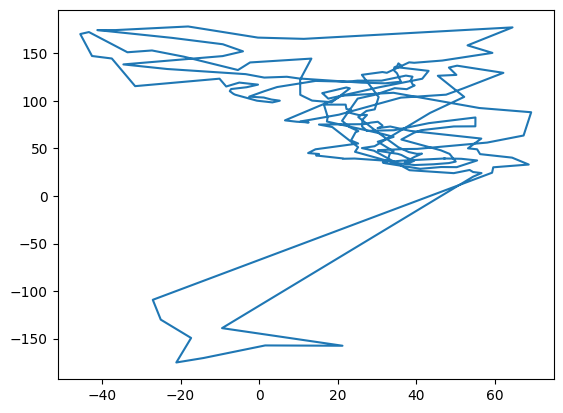

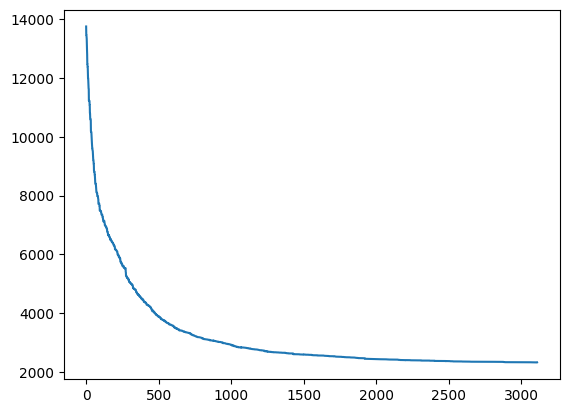

In [144]:
x, y, gen = genetic_algorithm(200, 600, 0.6, 1, 229) # data = 'gr229.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])

pt_arrx = np.zeros(229+1)
pt_arry = np.zeros(229+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(229):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[229] = s[0][0].copy()
pt_arry[229] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()

حال جمعیت و احتمال جهش را افزایش می دهیم.

نمودار شکل خیلی خوبی گرفته و پیشرفت الگوریتم را نشان می دهد

[2262.58470263]
[[ -34.55  138.35]
 [ -37.49  144.58]
 [ -42.53  147.19]
 [ -33.52  151.13]
 [ -27.28  153.02]
 [  -4.12  152.12]
 [  35.42  139.46]
 [  38.15  140.53]
 [  48.27  135.06]
 [  62.13  129.49]
 [  52.03  113.3 ]
 [  52.16  104.2 ]
 [  56.01   92.5 ]
 [  55.02   82.55]
 [  43.48   87.35]
 [  25.05  102.4 ]
 [  21.02  105.51]
 [  16.04  108.13]
 [  16.28  107.36]
 [  18.47   98.59]
 [  22.     96.05]
 [  22.2    91.5 ]
 [  25.2    83.  ]
 [  26.55   75.49]
 [  30.11   71.29]
 [  30.12   67.  ]
 [  30.17   57.05]
 [  30.2    48.16]
 [  30.3    47.47]
 [  29.2    47.59]
 [  26.13   50.35]
 [  25.17   51.32]
 [  29.36   52.32]
 [  32.4    51.38]
 [  34.19   47.04]
 [  38.05   46.18]
 [  40.11   44.3 ]
 [  41.43   44.49]
 [  50.     36.15]
 [  59.55   30.15]
 [  54.41   25.19]
 [  53.54   27.34]
 [  50.26   30.31]
 [  48.27   34.59]
 [  47.14   39.42]
 [  48.44   44.25]
 [  40.23   49.51]
 [  37.16   49.36]
 [  35.4    51.26]
 [  36.18   59.36]
 [  34.2    62.12]
 [  31.32   65.

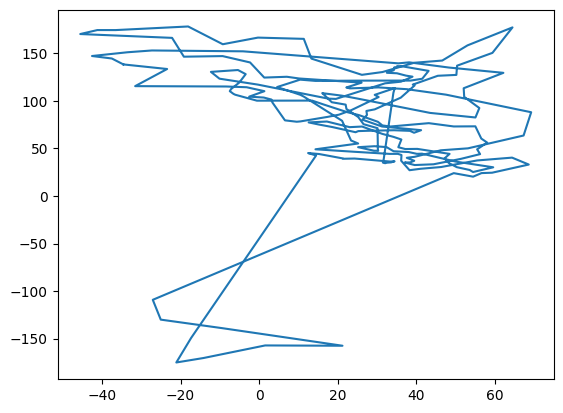

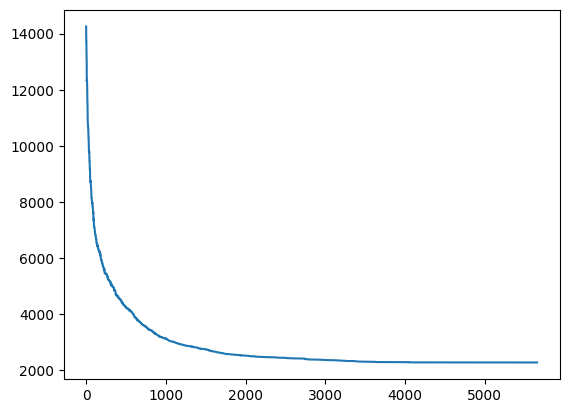

In [145]:
x, y, gen = genetic_algorithm(300, 600, 0.7, 1, 229) # data = 'gr229.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])

pt_arrx = np.zeros(229+1)
pt_arry = np.zeros(229+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(229):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[229] = s[0][0].copy()
pt_arry[229] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()

حال برای داده بعدی دنبال جواب می گردیم

pr1002

همان حالت نهایی برای داده های قبلی را امتحان می کنیم

در اینجا کد را کمی تغییر می دهیم به طوری که برای جواب نیاز به نسل (تکرار) بیشتر هست. (چون اجرا شدن خیلی زمان می برد، و هیچ وقت متوقف نیمشد (۱۰-۱۲ ساعت) مجبور شدم  این کار رو انجام بدم)

[2623908.4286184]
[[11004.  3557.]
 [ 5000.  2150.]
 [ 4900.  1550.]
 ...
 [13800.  9450.]
 [10700. 10250.]
 [ 9400.  6400.]]


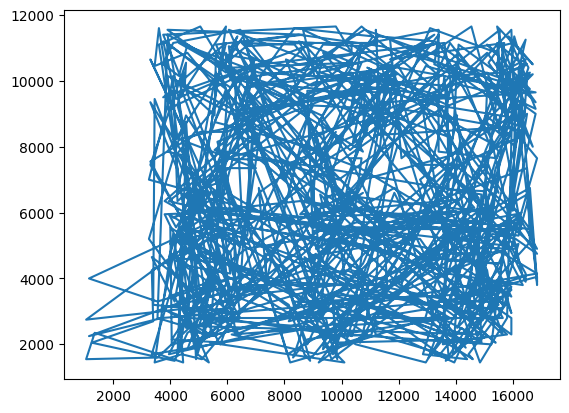

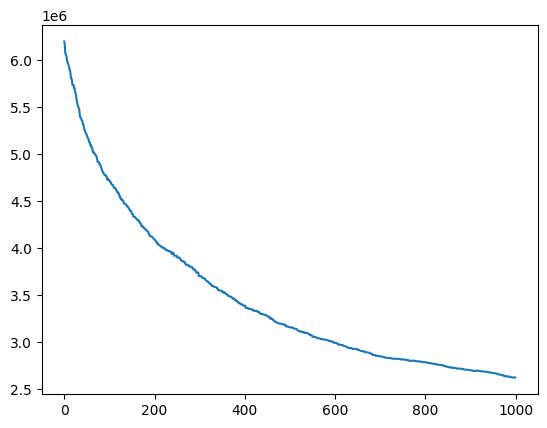

In [17]:
x, y, gen = genetic_algorithm(100, 1000, 0.6, 1, 1002) # data = 'pr1002.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])

pt_arrx = np.zeros(1002+1)
pt_arry = np.zeros(1002+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(1002):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[1002] = s[0][0].copy()
pt_arry[1002] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()

تعداد تکرار را ۱۰ برابر می کنیم و مشاهده می شود که جواب خیلی خوبی بدست می آید

[1187066.38648968]
[[3550. 2800.]
 [3700. 2800.]
 [4600. 2350.]
 ...
 [6850. 4050.]
 [5600. 3750.]
 [4450. 3500.]]


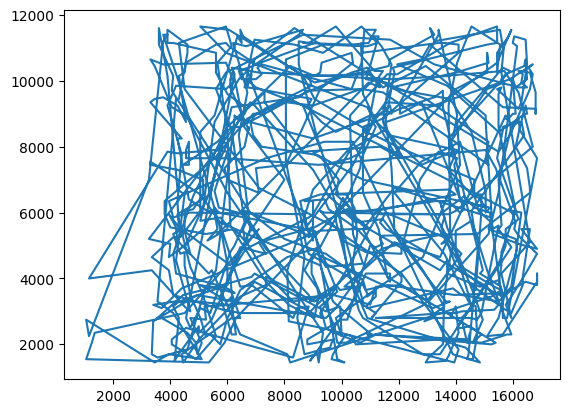

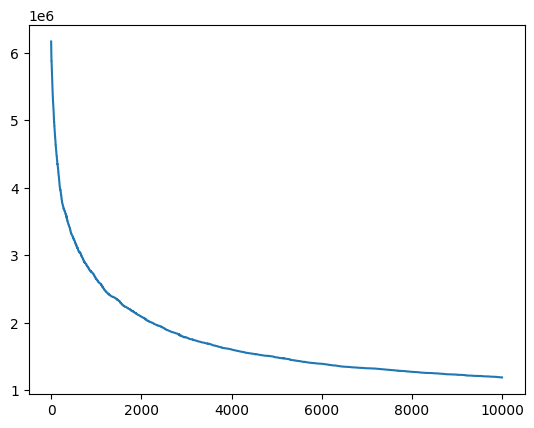

In [19]:
x, y, gen = genetic_algorithm(100, 10000, 0.6, 1, 1002) # data = 'pr1002.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])

pt_arrx = np.zeros(1002+1)
pt_arry = np.zeros(1002+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(1002):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[1002] = s[0][0].copy()
pt_arry[1002] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()

حال با تکرار ۱۰۰۰۰۰ بار امتحان می کنیم

مشاهده می کنیم که نمودار شکل بسیار خوبی دارد

و پاسخ ۸۵۸۴۶۳ بدست آمده.

[858463.12585945]
[[13600.  5250.]
 [11850.  5100.]
 [11450.  5300.]
 ...
 [12850.  4250.]
 [13500.  5050.]
 [13747.  5256.]]


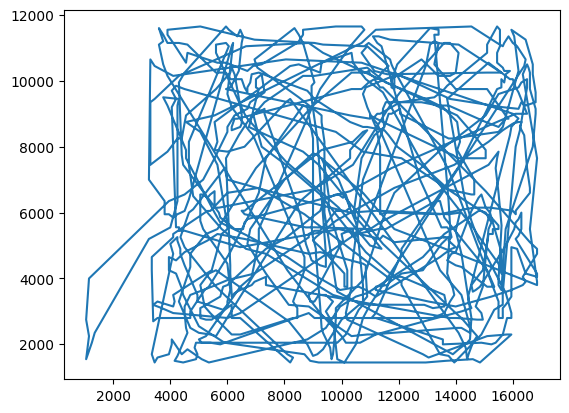

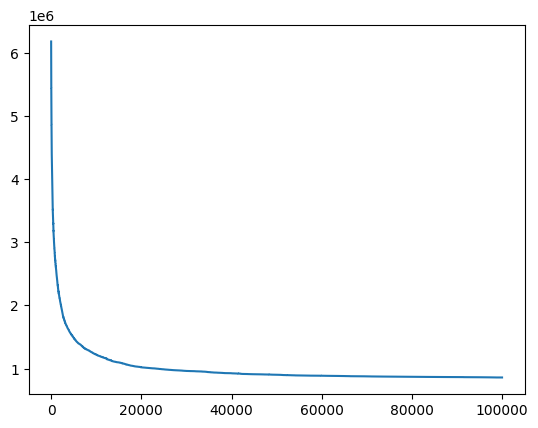

In [20]:
x, y, gen = genetic_algorithm(100, 100000, 0.6, 1, 1002) # data = 'pr1002.tsp'
print(x)
print(y[np.where(x == min(x))[0][0]])

pt_arrx = np.zeros(1002+1)
pt_arry = np.zeros(1002+1)

s = y[np.where(x == min(x))[0][0]]
for v in range(1002):
    pt_arrx[v] = s[v][0].copy()
    pt_arry[v] = s[v][1].copy()

pt_arrx[1002] = s[0][0].copy()
pt_arry[1002] = s[0][1].copy()

plt.clf()
plt.plot(pt_arrx, pt_arry)
plt.show()
plt.clf()
plt.plot(list(range(len(gen))), gen)
plt.show()